# Classification tables d'intérêt des pdf

#### Import

In [1]:
# pip install seaborn
# pip install joblib
# pip install scikit-learn
# pip install nltk
# nltk.download('stopwords')
# nltk.download('popular')

In [164]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from nltk.tokenize import word_tokenize
import seaborn as sns
import warnings
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
import pdfplumber
import joblib
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
import os

warnings.filterwarnings('ignore')

%config IPCompleter.greedy = True
%matplotlib inline

# Fonctions

In [21]:
def clean_text(text):
    porter = PorterStemmer()
    stop_words = set(stopwords.words())
    text = str(text)
    text = text.lower()
    text = re.sub('(<.*?>)|(\n)|([^\w\s\.\,])|([_])|([.])|([,])|(\s\s+)|([ا-ي])', '', text)
    cleaned_text = ' '.join([porter.stem(i) for i in word_tokenize(text) if i not in stop_words])
    return cleaned_text

def cleaning_pdf_interest(df, col_name):
    cleaned_column = df[col_name].apply(clean_text)
    return cleaned_column

In [97]:
def plot_roc_curve(y_test, y_prob):
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure(figsize=(8, 8))

    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')

    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    
    plt.show()

In [153]:
def show_coef(coef, features_names):
    coef_abs = abs(coef)
    features_index_desc = np.argsort(coef_abs)[::-1]
    lr_best_index = features_index_desc[:10]
    for index in lr_best_index:
        print(f' feature : {index} :', {features_names[index]})

# Chargement des données

In [6]:
train_data_path = "data/temp/train_dataset/csv/table_dataset.csv"
train_data_path

'data/temp/train_dataset/csv/table_dataset.csv'

In [48]:
train_df = pd.read_csv(train_data_path, delimiter=';', encoding="utf-8-sig")
train_df.head()

,Unnamed: 0,path,page,is_scan,text,interest_table
0,0,C:\Users\jeanm\Downloads\DOC DATA CHALLENGE\DO...,0,False,MARK NO. QTY SIZE SERIES FACING TYPE MIN. HOLE...,1
1,1,C:\Users\jeanm\Downloads\DOC DATA CHALLENGE\DO...,1,False,CONFIDENTIAL THIS DRAWING IS THE SOLE PROPERTY...,0
2,2,C:\Users\jeanm\Downloads\DOC DATA CHALLENGE\DO...,0,True,Part Numbers DESCRIPTION | QTY|(*) spare par...,1
3,3,C:\Users\jeanm\Downloads\DOC DATA CHALLENGE\DO...,1,True,Part Numbers DESCRIPTION tiha (*) spare parts...,1
4,4,C:\Users\jeanm\Downloads\DOC DATA CHALLENGE\DO...,0,False,PROPIEDAD EXCLUSIVA MILTON ROY EUROPE - COMUNI...,0


Correction du type de la colonne interest_table.

In [60]:
train_df['interest_table'] = train_df['interest_table'].astype(int)

In [61]:
train_set = train_df[['text', 'interest_table']]
train_set.head()

,text,interest_table
0,MARK NO. QTY SIZE SERIES FACING TYPE MIN. HOLE...,1
1,CONFIDENTIAL THIS DRAWING IS THE SOLE PROPERTY...,0
2,Part Numbers DESCRIPTION | QTY|(*) spare par...,1
3,Part Numbers DESCRIPTION tiha (*) spare parts...,1
4,PROPIEDAD EXCLUSIVA MILTON ROY EUROPE - COMUNI...,0


# Observation des données

In [62]:
train_set['interest_table'].value_counts()

0    601
1    147
Name: interest_table, dtype: int64

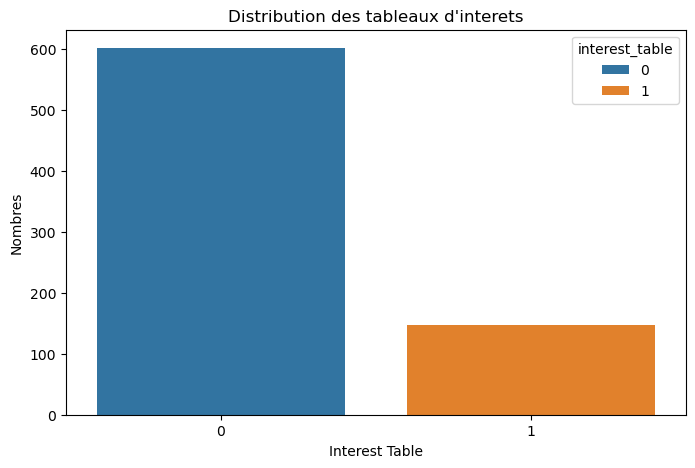

In [63]:
plt.figure(figsize=(8, 5))
sns.countplot(data=train_set, x='interest_table', hue='interest_table')

plt.xlabel('Interest Table')
plt.ylabel('Nombres')
plt.title("Distribution des tableaux d'interets")

plt.show()

# Nettoyage des données

In [64]:
train_set_cleaned = train_set.copy()
train_set_cleaned['text'] = cleaning_pdf_interest(train_set_cleaned,'text')

In [66]:
train_set_cleaned['text'][:5]

0    mark qti size seri face type hole id neckservi...
1    confidenti draw sole properti peerlessmfg comp...
2    part numbersdescript qti spare partsrecommende...
3    part number descript tiha spare partsrecommend...
4    propiedad exclusiva milton roy europ comunicac...
Name: text, dtype: object

# Analyse des données

In [67]:
words = [word for line in train_set_cleaned["text"].tolist() for word in line.split()]
len(words)

66809

In [45]:
# Counter(words)

# Division des données

In [68]:
X = train_set_cleaned['text'].tolist()
y = train_set_cleaned['interest_table'].tolist()

In [88]:
# TO DO: Bien comprendre l'usage de l'attribut 'stratify'
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

### Vectorisation 

In [ ]:
tfidf_vector = TfidfVectorizer(stop_words='english', max_features=None, max_df=0.5, min_df=2, ngram_range=(1,1))
features_names = tfidf_vector.get_feature_names_out()

In [89]:
X_train = tfidf_vector.fit_transform(X_train)
X_test = tfidf_vector.transform(X_test)

## Model

## 1- Logistic regression

In [90]:
lr = LogisticRegression(random_state=42)
lr = lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94       181
           1       1.00      0.48      0.65        44

    accuracy                           0.90       225
   macro avg       0.94      0.74      0.79       225
weighted avg       0.91      0.90      0.88       225



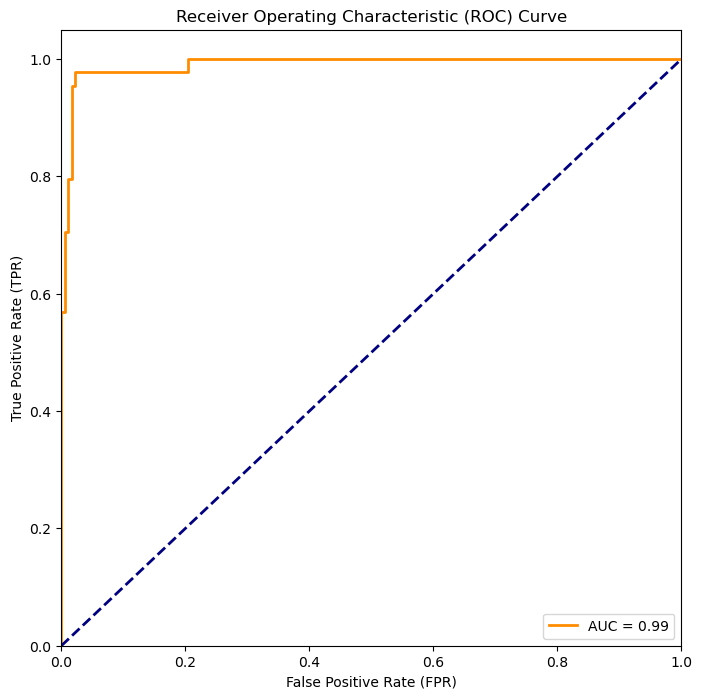

In [96]:
y_prob = lr.predict_proba(X_test)[:, 1]
plot_roc_curve(y_test, y_prob)

In [156]:
show_coef(lr.coef_[0], features_names)

 feature : 2098 : {'pc'}
 feature : 2145 : {'pospart'}
 feature : 274 : {'135'}
 feature : 2092 : {'pagina'}
 feature : 1524 : {'design'}
 feature : 1196 : {'a1003366'}
 feature : 1730 : {'gener'}
 feature : 1726 : {'gasket'}
 feature : 1639 : {'engineproduct'}
 feature : 1558 : {'document'}


## 2-Random forest

In [145]:
rf = RandomForestClassifier(min_samples_split=5 ,max_depth=10, random_state=42)
rf = rf.fit(X_train, y_train)
y_pred2 = rf.predict(X_test)

In [146]:
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97       181
           1       1.00      0.73      0.84        44

    accuracy                           0.95       225
   macro avg       0.97      0.86      0.91       225
weighted avg       0.95      0.95      0.94       225



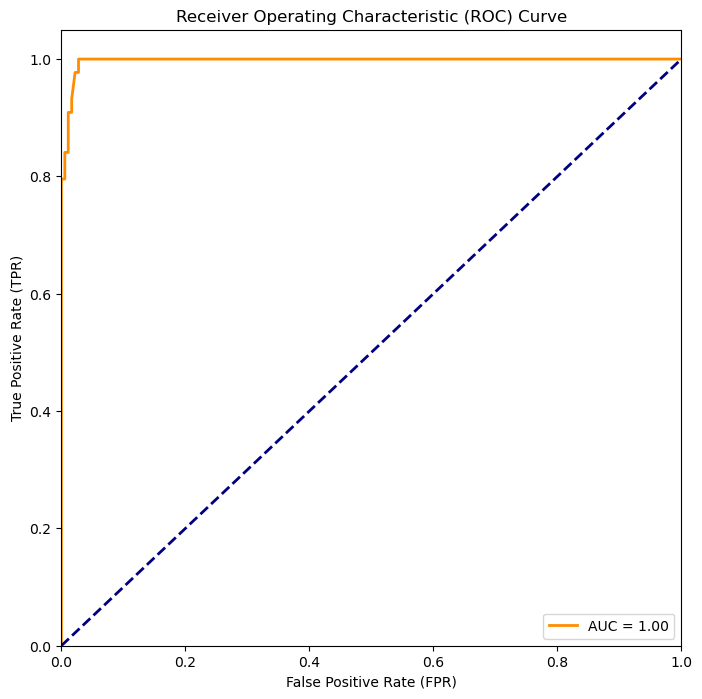

In [147]:
y_prob = rf.predict_proba(X_test)[:, 1]
plot_roc_curve(y_test, y_prob)

In [157]:
show_coef(rf.feature_importances_, features_names)

 feature : 2180 : {'qti'}
 feature : 2098 : {'pc'}
 feature : 2145 : {'pospart'}
 feature : 1524 : {'design'}
 feature : 2134 : {'po'}
 feature : 2524 : {'u3ei3cuuueinii'}
 feature : 2559 : {'unit'}
 feature : 1466 : {'copyright'}
 feature : 1928 : {'list'}
 feature : 2623 : {'weight'}


## 3-LinearSV

In [159]:
svm = LinearSVC(random_state=42)
svm = svm.fit(X_train, y_train)
y_pred3 = svm.predict(X_test)
print(classification_report(y_test, y_pred3))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98       181
           1       1.00      0.80      0.89        44

    accuracy                           0.96       225
   macro avg       0.98      0.90      0.93       225
weighted avg       0.96      0.96      0.96       225



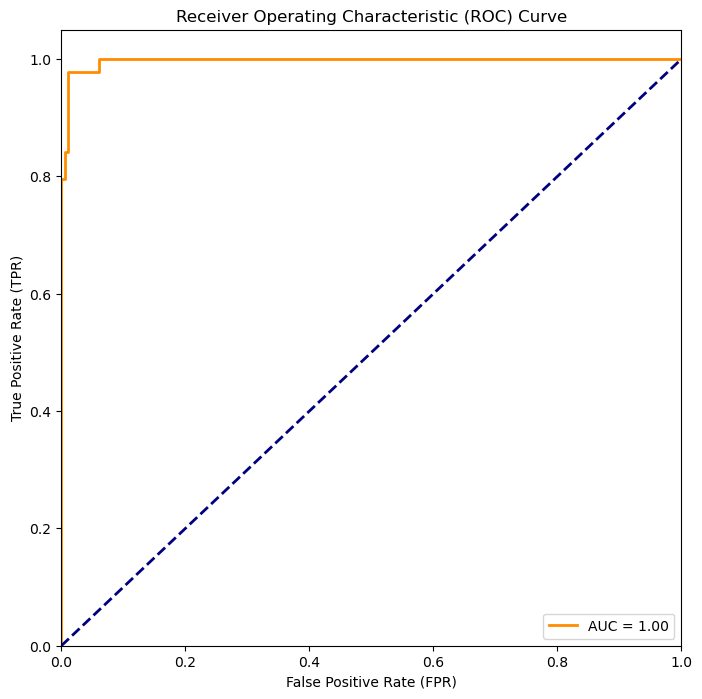

In [160]:
y_scores = svm.decision_function(X_test)
plot_roc_curve(y_test, y_scores)

In [162]:
show_coef(svm.coef_[0], features_names)

 feature : 2145 : {'pospart'}
 feature : 274 : {'135'}
 feature : 1236 : {'aae'}
 feature : 1730 : {'gener'}
 feature : 2386 : {'serial'}
 feature : 1524 : {'design'}
 feature : 2079 : {'ooo'}
 feature : 1196 : {'a1003366'}
 feature : 1726 : {'gasket'}
 feature : 2036 : {'nan'}


# Sauvegarde des modèles 

In [168]:
os.makedirs('results/table_classifier_models', exist_ok=True)

In [170]:
joblib.dump(lr, 'results/table_classifier_models/lr_model.pk')
joblib.dump(rf, 'results/table_classifier_models/rf_model.pkl')
joblib.dump(svm, 'results/table_classifier_models/svm_model.pkl')

['results/table_classifier_models/svm_model.pkl']

# Test sur les données non annotées

In [41]:
lr_model = joblib.load('./table_classifier_models/lr_model.pk')
lr_model = joblib.load('./table_classifier_models/rf_model.pkl')
svm_model = joblib.load('./table_classifier_models/svm_model.pkl')

In [68]:
# from exttraction_for_inference import extract_data

In [42]:
test_path = r'test_datasets/csv/table_dataset.csv'


test_data = pd.read_csv(test_path, delimiter=";")
test_data['text'] = cleaning_pdf_interest(test_data, 'text')
y_test_data = tfidf_vector.transform(test_data['text'].tolist())

In [43]:
pred = lr_model.predict(y_test_data)

In [45]:
test_data['is_interest'] = pred

In [46]:
os.makedirs('Prediction')

In [47]:
test_data.to_csv('Prediction/lr_prediction.csv')

In [48]:
test_data

,Unnamed: 0,path,page,is_scan,text,is_interest
0,0,C:\Users\jeanm\Downloads\DOC DATA CHALLENGE\DO...,0,False,item revis equip instrument tag number manufac...,1
1,1,C:\Users\jeanm\Downloads\DOC DATA CHALLENGE\DO...,1,False,item revis equip instrument tag number manufac...,1
2,2,C:\Users\jeanm\Downloads\DOC DATA CHALLENGE\DO...,2,False,item revis equip instrument tag number manufac...,1
3,3,C:\Users\jeanm\Downloads\DOC DATA CHALLENGE\DO...,3,False,itwm revis equip instrument tag number manufac...,1
4,4,C:\Users\jeanm\Downloads\DOC DATA CHALLENGE\DO...,4,False,itwm revis equip instrument tag number manufac...,0
...,...,...,...,...,...,...
719,719,C:\Users\jeanm\Downloads\DOC DATA CHALLENGE\DO...,5,True,refno partno sapno spare part list typ rvp4 pr...,0
720,720,C:\Users\jeanm\Downloads\DOC DATA CHALLENGE\DO...,0,False,d103247xus2 instal guid englishmarch 2015 type...,0
721,721,C:\Users\jeanm\Downloads\DOC DATA CHALLENGE\DO...,1,False,2 type mr108 accumul prevent suchinjuri damag ...,0
722,722,C:\Users\jeanm\Downloads\DOC DATA CHALLENGE\DO...,2,False,3 type mr108 part list keydescript 1valv bodi ...,1


In [49]:
test_data.path[0]

'C:\\Users\\jeanm\\Downloads\\DOC DATA CHALLENGE\\DOC DATA CHELLENGE\\SPARE_DOCUMENT\\ASCEA-10-Q24048-0002_02 - CE WHP - FST- Instrument Air Package - Operational Spare Parts List For Instrument Air Compressor & Dryer Package (ASCEA-A-5451-5452).pdf'

In [90]:
path1 = r'C:\Users\jeanm\Downloads\DOC DATA CHALLENGE\DOC DATA CHELLENGE\SPARE_DOCUMENT'
path2 = r'C:\Users\s.doudou\Documents\GEEK\DATA\SPARE_DOCUMENT'
test_data['path'] =test_data.path.apply(lambda x: x.replace(path1, path2))

In [50]:
test_data

,Unnamed: 0,path,page,is_scan,text,is_interest
0,0,C:\Users\jeanm\Downloads\DOC DATA CHALLENGE\DO...,0,False,item revis equip instrument tag number manufac...,1
1,1,C:\Users\jeanm\Downloads\DOC DATA CHALLENGE\DO...,1,False,item revis equip instrument tag number manufac...,1
2,2,C:\Users\jeanm\Downloads\DOC DATA CHALLENGE\DO...,2,False,item revis equip instrument tag number manufac...,1
3,3,C:\Users\jeanm\Downloads\DOC DATA CHALLENGE\DO...,3,False,itwm revis equip instrument tag number manufac...,1
4,4,C:\Users\jeanm\Downloads\DOC DATA CHALLENGE\DO...,4,False,itwm revis equip instrument tag number manufac...,0
...,...,...,...,...,...,...
719,719,C:\Users\jeanm\Downloads\DOC DATA CHALLENGE\DO...,5,True,refno partno sapno spare part list typ rvp4 pr...,0
720,720,C:\Users\jeanm\Downloads\DOC DATA CHALLENGE\DO...,0,False,d103247xus2 instal guid englishmarch 2015 type...,0
721,721,C:\Users\jeanm\Downloads\DOC DATA CHALLENGE\DO...,1,False,2 type mr108 accumul prevent suchinjuri damag ...,0
722,722,C:\Users\jeanm\Downloads\DOC DATA CHALLENGE\DO...,2,False,3 type mr108 part list keydescript 1valv bodi ...,1


## document scannée et d'interer

In [51]:
test_data[(test_data.is_scan == True) & (test_data.is_interest ==1)]

,Unnamed: 0,path,page,is_scan,text,is_interest
43,43,C:\Users\jeanm\Downloads\DOC DATA CHALLENGE\DO...,2,True,typic eex eex motor 1 2 3 4 5 6 7 8 9 10 11 12...,1
120,120,C:\Users\jeanm\Downloads\DOC DATA CHALLENGE\DO...,0,True,2 32 item w m3 7000 4200 4000 112 7000 4200 40...,1
121,121,C:\Users\jeanm\Downloads\DOC DATA CHALLENGE\DO...,1,True,3 32 01a 25 item po qti 001 1 pressur nozzl au...,1
122,122,C:\Users\jeanm\Downloads\DOC DATA CHALLENGE\DO...,2,True,4 32 01b 25 item po qti 001 1 pack list eng pk...,1
123,123,C:\Users\jeanm\Downloads\DOC DATA CHALLENGE\DO...,3,True,5 32 02ab 25 item po qti 001 1 002 1 003 4 004...,1
124,124,C:\Users\jeanm\Downloads\DOC DATA CHALLENGE\DO...,4,True,6 32 03a 25 item po qti 001 02 1 wooden box pn...,1
125,125,C:\Users\jeanm\Downloads\DOC DATA CHALLENGE\DO...,5,True,7 32 03b 25 item po qti 001 02 1 wooden box pn...,1
126,126,C:\Users\jeanm\Downloads\DOC DATA CHALLENGE\DO...,6,True,8 32 04a 25 item po qti 001 05 1 wooden box pn...,1
127,127,C:\Users\jeanm\Downloads\DOC DATA CHALLENGE\DO...,7,True,9 32 04b 25 item po qti 001 06 1 wooden box pn...,1
128,128,C:\Users\jeanm\Downloads\DOC DATA CHALLENGE\DO...,8,True,10 32 05a 25 item po qti 001 05 1 wooden box p...,1


In [53]:
pip install pdfplumber

     ---------------------------------------- 0.0/5.6 MB ? eta -:--:--
     ---------------------------------------- 0.0/5.6 MB ? eta -:--:--
     ---------------------------------------- 0.0/5.6 MB ? eta -:--:--
      --------------------------------------- 0.1/5.6 MB 558.5 kB/s eta 0:00:10
      --------------------------------------- 0.1/5.6 MB 726.2 kB/s eta 0:00:08
      --------------------------------------- 0.1/5.6 MB 726.2 kB/s eta 0:00:08
     - -------------------------------------- 0.2/5.6 MB 610.0 kB/s eta 0:00:09
     - -------------------------------------- 0.2/5.6 MB 655.4 kB/s eta 0:00:09
     - -------------------------------------- 0.2/5.6 MB 588.9 kB/s eta 0:00:10
     - -------------------------------------- 0.2/5.6 MB 550.0 kB/s eta 0:00:10
     - -------------------------------------- 0.2/5.6 MB 553.5 kB/s eta 0:00:10
     - -------------------------------------- 0.3/5.6 MB 524.0 kB/s eta 0:00:11
     - -------------------------------------- 0.3/5.6 MB 516.0 kB/s

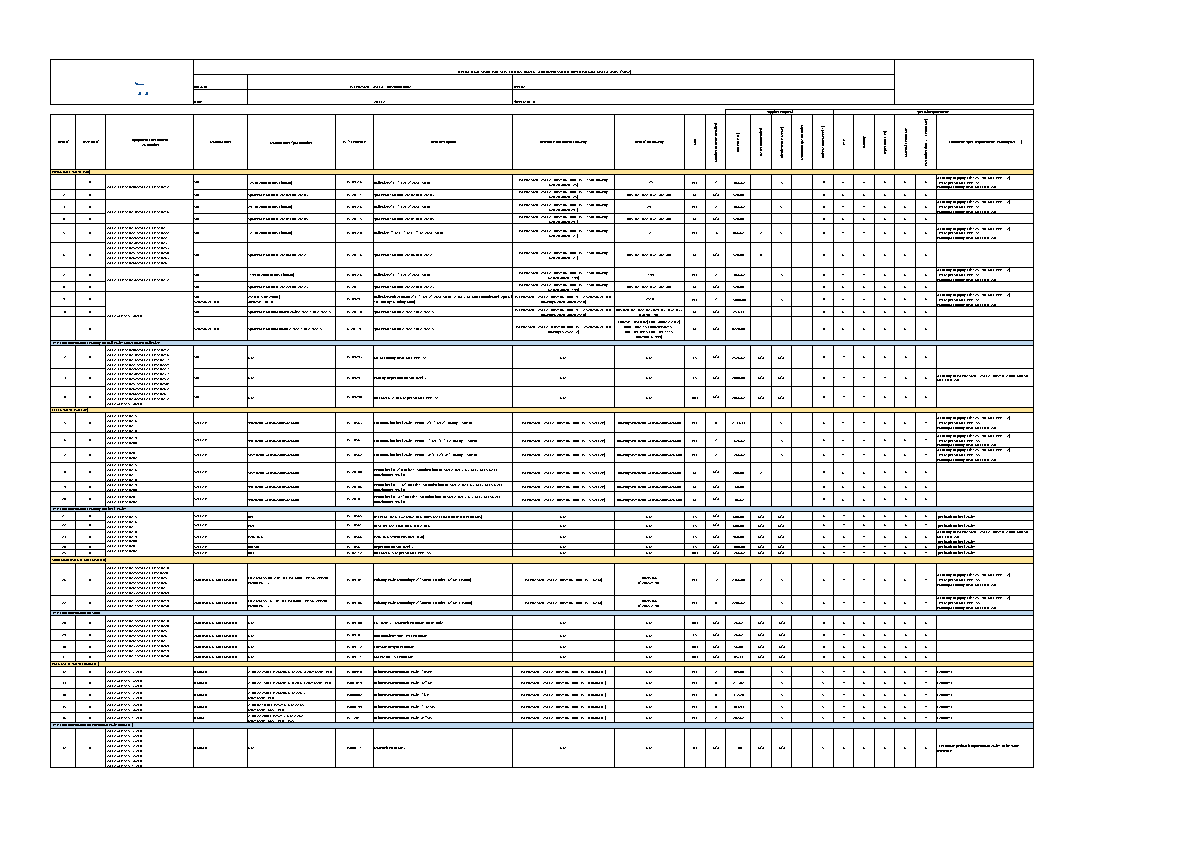

In [54]:
page_number = 0
pdf_path = test_data['path'][0]

with pdfplumber.open(pdf_path) as pdf:
    pages = pdf.pages
    page = pages[page_number]
page.to_image()


## Table d'interret issue d'u tableau scannée

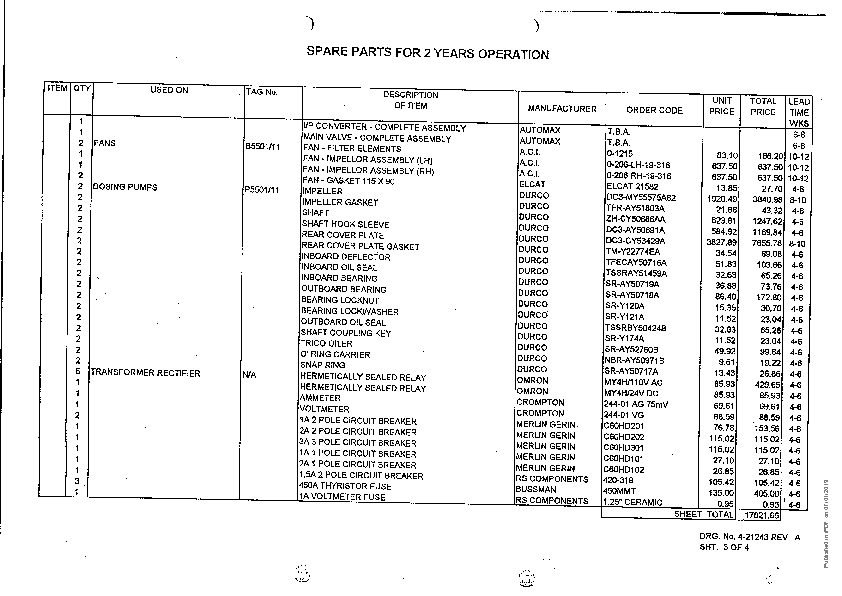

In [55]:
page_number = 1
pdf_path = test_data['path'][63]

with pdfplumber.open(pdf_path) as pdf:
    pages = pdf.pages
    page = pages[page_number]
page.to_image()